### Authors : Akeniouene & Boutaleb
### Classification de textes
#### Questions

Identification du thème du document

    Télécharger les données Reuters-21578
    Extraire les textes (body) ainsi que les catégories (topics) qui leur sont associées. Garder les textes étiquetés avec les 4 catégories les plus fréquentes.
    Les tokeniser en utilisant spacy
    Représenter chaque texte par un vecteur sac-de-mots.
    En utilisant la représentation précédente entraîner une classifieur bayésien naïf. Observer les paramétres du modèle. Rapporter les performance du modèle en termes de Précision/Rappel/Score_F1.






In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from bs4 import BeautifulSoup, SoupStrainer
import pandas as pd
import numpy as np
import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
from sklearn import metrics


In [2]:
l_topics = []
l_title = []
l_body = []

for i in range(22):
    if i == 17:
        continue

    file_name = f'reuters21578/reut2-{i:03d}.sgm'
    f = open(file_name, 'r')
    data = f.read()

    soup = BeautifulSoup(data, "html.parser")
    contents = soup.findAll('reuters')

    topic_err, title_err, body_err = 0, 0, 0

    for content in contents:
        try:
            # The list of all topics associated to each <reuters>
            topics = content.findAll("topics")[0].findAll("d")
            tmp_topics = []
            for topic in topics:
                tmp_topics += [topic.text]

            if len(tmp_topics) == 0:
                topic_err += 1
                l_topics += ['Unkown']
            else:
                l_topics += [tmp_topics[0]]

        except:
            topic_err += 1
            l_topics += ['Unkown']

        try:
            title = content.findAll("title")[0].text
            l_title += [title]
        except:
            title_err += 1
            l_title += ['Unkown']

        try:
            body = content.findAll("body")[0].text
            l_body += [body]
        except:
            body_err += 1
            l_body += ['Unkown']


reuteurs_df = pd.DataFrame()
reuteurs_df['topics'] = l_topics
reuteurs_df['title'] = l_title
reuteurs_df['body'] = l_body
reuteurs_df


,topics,title,body
0,cocoa,BAHIA COCOA REVIEW,Showers continued throughout the week in\nthe ...
1,Unkown,STANDARD OIL <SRD> TO FORM FINANCIAL UNIT,Standard Oil Co and BP North America\nInc said...
2,Unkown,TEXAS COMMERCE BANCSHARES <TCB> FILES PLAN,Texas Commerce Bancshares Inc's Texas\nCommerc...
3,Unkown,TALKING POINT/BANKAMERICA <BAC> EQUITY OFFER,BankAmerica Corp is not under\npressure to act...
4,grain,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department\nreported the ...
...,...,...,...
20573,ship,JAPAN/INDIA CONFERENCE CUTS GULF WAR RISK CHARGES,The Japan/India-Pakistan-Gulf/Japan\nshipping ...
20574,ipi,SOVIET INDUSTRIAL GROWTH/TRADE SLOWER IN 1987,The Soviet Union's industrial output is\ngrowi...
20575,gold,SIX KILLED IN SOUTH AFRICAN GOLD MINE ACCIDENT,Six black miners have been killed\nand two inj...
20576,Unkown,PROJECTIONS SHOW SWISS VOTERS WANT TRIED PARTIES,The prospect of a dominant alliance of\nsocial...


We select all the topics that does not interest us

In [3]:
topics_not_to_consider = reuteurs_df.groupby(['topics'])['title'].count(
).reset_index().sort_values(['title'], ascending=False)[6:]['topics']


We drop those rows that are associated to the topics above

In [4]:
reuteurs_df = reuteurs_df.drop(
    reuteurs_df[reuteurs_df.topics.isin(list(topics_not_to_consider))].index)


In [5]:
reuteurs_df.topics.unique()


array(['Unkown', 'grain', 'earn', 'acq', 'crude', 'money-fx'],
      dtype=object)

We make the choice to drop even unknown topics, since we are trying to classify

In [6]:
reuteurs_df = reuteurs_df.drop(
    reuteurs_df[reuteurs_df.topics == 'Unkown'].index)


So we end up with only 7.8k rows with 5 classes or labels

In [7]:
reuteurs_df.shape


(7824, 3)

In [8]:
reuteurs_df = reuteurs_df.reset_index()


In [9]:
reuteurs_df.drop('index', axis=1, inplace=True)


In [10]:
reuteurs_df


,topics,title,body
0,grain,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department\nreported the ...
1,earn,CHAMPION PRODUCTS <CH> APPROVES STOCK SPLIT,Champion Products Inc said its\nboard of direc...
2,acq,COMPUTER TERMINAL SYSTEMS <CPML> COMPLETES SALE,Computer Terminal Systems Inc said\nit has com...
3,earn,COBANCO INC <CBCO> YEAR NET,"Shr 34 cts vs 1.19 dlrs\n Net 807,000 vs 2,..."
4,earn,OHIO MATTRESS <OMT> MAY HAVE LOWER 1ST QTR NET,"Ohio Mattress Co said its first\nquarter, endi..."
...,...,...,...
7819,money-fx,ECONOMIST URGES MORE TAXES TO LOWER N.Z. DOLLAR,An income tax surcharge and capital\ngains tax...
7820,crude,"IRAN, SOVIET UNION TO SWAP CRUDE, REFINED PROD...",The Soviet Union has agreed to supply\nIran wi...
7821,grain,THAI RICE EXPORTS RISE IN WEEK TO OCTOBER 13,"Thai rice exports rose to 72,987 tonnes\nin th..."
7822,acq,N.Z.'S CHASE CORP MAKES OFFER FOR ENTREGROWTH,Chase Corp Ltd <CHCA.WE> said it will\nmake an...


In [11]:
reuteurs_df.to_csv('reuters_df.csv')


Example of text tokenizer

In [12]:
nlp = spacy.load("en_core_web_sm")
text = reuteurs_df['body'][0]
my_doc = nlp(text)

# Create list of words
token_list = []
for token in my_doc:
    token_list.append(token.text)


In [1]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('First ten stop words: %s' % list(spacy_stopwords)[:10])


NameError: name 'spacy' is not defined

In [14]:
punctuations = string.punctuation
nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS


def preprocess_text_clean(msg):
    msg = msg.replace('\n', ' ')
    msg = msg.replace('\r', ' ')
    msg = msg.replace('-- ', ' ')
    msg = msg.replace('Reuter\x03', ' ')
    msg = msg.replace('REUTER\x03', ' ')
    msg = msg.replace('Reuter \x03', ' ')

    # remove <tag>
    msg = msg.replace('<', ' ')
    msg = msg.replace('>', ' ')

    # remove  -
    msg = msg.replace(' - ', ' ')

    # reformat  ,
    msg = msg.replace(' , ', ', ')

    # join tokens
    msg = ' '.join(msg.split())

    return msg


def spacy_tokenizer(sentence):

    mytokens = nlp(sentence)

    # Lemmatizing each token and converting each token into lowercase
    # if word.lemma_ != "-PRON-" , is used to avoid the "-PRON-" the default lemma for pronouns in spaCy

    mytokens = [word.lemma_.lower().strip() if word.lemma_ !=
                "-PRON-" else word.lower_ for word in mytokens]

    # Removing stop words and ponctuation
    mytokens = [
        word for word in mytokens if word not in stop_words and word not in punctuations]

    return mytokens


In [15]:
bow_vector = CountVectorizer( preprocessor=preprocess_text_clean, tokenizer=spacy_tokenizer, ngram_range=(1, 1))


In [16]:
y = reuteurs_df['topics'].astype("category").cat.codes
X = reuteurs_df['body']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


Tokenizer test

In [17]:
spacy_tokenizer(X_train[0])[:5]


['u.s.', 'agriculture', 'department', 'report', 'farmer']

In [ ]:
X_train[:5], y_train[:5]


Vectorizer

In [19]:
X_train = bow_vector.fit_transform(X_train)


In [20]:
X_train.toarray().shape


(6259, 28575)

In [21]:
# classifier = LogisticRegression()
classifier = GaussianNB()

classifier.fit(X_train.toarray(), y_train)


GaussianNB()

Transforming Test data

In [22]:
tmp = bow_vector.transform(X_test)


Prediction

In [23]:
# Predicting with a test dataset
predicted = classifier.predict(tmp.toarray())

# Model Accuracy
print("Naive bayes Accuracy:", metrics.accuracy_score(y_test, predicted))
print("Naive bayes Precision:", metrics.precision_score(
    y_test, predicted, average='weighted'))
print("Naive bayes Recall:", metrics.recall_score(
    y_test, predicted, average='weighted'))
print("Naive bayes score_f1:", metrics.f1_score(
    y_test, predicted, average='weighted'))


Naive bayes Accuracy: 0.7904153354632588
Naive bayes Precision: 0.8218383410924799
Naive bayes Recall: 0.7904153354632588
Naive bayes score_f1: 0.7980526555365665


## Second part : Amazon Reviews



Classification de sentiments

    Télécharger les données sacs-de-mots (version ACL) d'avis sur des produits d'amazon. Observer les tokens choisis. Que constatez vous?
    Entraîner un classifieur de sentiments pour ce jeu de données d'avis. Rapporter les performance du modèle en termes de Précision/Rappel/Score_F1.


Reading all the data

In [24]:
def get_data(path, label_type):
    print(path)
    f = open(path, 'r')
    data = f.read()
    data = data.split(' #label#:'+label_type)
    data = [re.sub(r'\n', '', data[i]).split²(' ') for i in range(len(data))]
    data_ = [[re.sub('.*?:', '', data[i][j])
              for j in range(len(data[i]))] for i in range(len(data))]

    for elem in range(len(data_)):
        for j in range(len(data_[elem])):
            if data_[elem][j] != '':
                data_[elem][j] = int(data_[elem][j])

    data = [[re.sub(':.', '', data[i][j])
             for j in range(len(data[i]))] for i in range(len(data))]
    for i in range(len(data)):
        for j in range(len(data[i])):
            if data_[i][j] != '' and data_[i][j] > 1:
                for k in range(data_[i][j]):
                    data[i].append(data[i][j])

    X_ = data[:-1]

    joined_items = []
    for i in range(len(X_)):
        joined_items += [(' ').join(X_[i])]

    tmp = 1 if label_type == 'positive' else 0
    y_ = [tmp]*len(X_)
    return joined_items, y_


In [25]:

def read_all_files():
    X_ = []
    y_ = []
    files_names = ['books', 'dvd', 'electronics', 'kitchen']
    for file in files_names:
        X_neg, y_neg = get_data('processed_acl/'+file +
                                '/negative.review', 'negative')
        X_pos, y_pos = get_data('processed_acl/'+file +
                                '/positive.review', 'positive')
        X_ += X_neg + X_pos
        y_ += y_neg + y_pos
    return X_, np.array(y_)


In [26]:
X_, y_ = read_all_files()


processed_acl/books/negative.review
processed_acl/books/positive.review
processed_acl/dvd/negative.review
processed_acl/dvd/positive.review
processed_acl/electronics/negative.review
processed_acl/electronics/positive.review
processed_acl/kitchen/negative.review
processed_acl/kitchen/positive.review


In [27]:
X_[0]


"avid your horrible_book wasted use_it the_entire money.i i_lit i_read lit i_would relationship read a_<num> reader_and reader suffering fire_one i_had year_old gotten horrible lit_this world...don't my one_star headache_the this_book mom was_horrible friend book_horrible star_i back avid_reader than_one life copy rate_it rate my_mom man book_was half on_fire and_then reading_this so lower i_could <num>_year than time half_of time_spent then book and_picked possible spent old_man up_after one horrible_if one_less part was entire less_copy to_rate my_life about_the your_money.i an_avid if the_relationship use a_headache fire lower_than reading a_friend picked purposes then_got waste_your after_my friend_i old man_and and_i world...don't_waste book_on part_about copy_in book_back book_wasted have_i time_and the_world...don't better if_it star got mom_had read_half waste after i about could_use had_gotten was_possible year it_lower relationship_the wasted_my wish wish_i boy purposes_this 

Spliting to train/test

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2)


CountVectorizer with ngrams up to (1,1), we should have greater metric results with an appropriate hyperparametrisation of the ngram range

In [29]:
c = CountVectorizer(ngram_range=(1, 1))


In [30]:
train_vector_entity = c.fit_transform(X_train)


In [31]:
train_vector_entity.shape


(6400, 361879)

In [32]:
y_train.shape


(6400,)

In [33]:
classifier_ = MultinomialNB()

classifier_.fit(train_vector_entity, y_train)


MultinomialNB()

Transforming data

In [34]:
test_vector_entity = c.transform(X_test)


In [35]:
predicted_ = classifier_.predict(test_vector_entity)

print("Multinomial Naive bayes Accuracy:",
      metrics.accuracy_score(y_test, predicted_))
print("Multinomial Naive bayes Precision:", metrics.precision_score(
    y_test, predicted_, average='weighted'))
print("Multinomial Naive bayes Recall:", metrics.recall_score(
    y_test, predicted_, average='weighted'))
print("Multinomial Naive bayes score_f1:", metrics.f1_score(
    y_test, predicted_, average='weighted'))


Multinomial Naive bayes Accuracy: 0.846875
Multinomial Naive bayes Precision: 0.8473027355844107
Multinomial Naive bayes Recall: 0.846875
Multinomial Naive bayes score_f1: 0.8468475420662723


## ***Partie 3***

Joining all bodies of the reuters_df and separate with    ``mlnlp`` each body from another

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from bs4 import BeautifulSoup, SoupStrainer
import pandas as pd
import numpy as np
import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
from sklearn import metrics


def preprocess_text_clean(msg):
    msg = msg.replace('\n', ' ')
    msg = msg.replace('\r', ' ')
    msg = msg.replace('-- ', ' ')
    msg = msg.replace('Reuter\x03', ' ')
    msg = msg.replace('REUTER\x03', ' ')
    msg = msg.replace('Reuter \x03', ' ')
    msg = msg.replace('REUTER \x03', ' ')
    msg = msg.replace('\d+', ' ')
    # remove <tag>
    msg = msg.replace('<', ' ')
    msg = msg.replace('>', ' ')
    # remove  -
    msg = msg.replace(' - ', ' ')
    # reformat  ,
    msg = msg.replace(' , ', ', ')
    # join tokens
    msg = ' '.join(msg.split())

    return msg


In [2]:
reuteurs_df = pd.read_csv('reuters_df.csv')


In [3]:
reuteurs_df


,Unnamed: 0,topics,title,body
0,0,grain,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department\nreported the ...
1,1,earn,CHAMPION PRODUCTS <CH> APPROVES STOCK SPLIT,Champion Products Inc said its\nboard of direc...
2,2,acq,COMPUTER TERMINAL SYSTEMS <CPML> COMPLETES SALE,Computer Terminal Systems Inc said\nit has com...
3,3,earn,COBANCO INC <CBCO> YEAR NET,"Shr 34 cts vs 1.19 dlrs\n Net 807,000 vs 2,..."
4,4,earn,OHIO MATTRESS <OMT> MAY HAVE LOWER 1ST QTR NET,"Ohio Mattress Co said its first\nquarter, endi..."
...,...,...,...,...
7819,7819,money-fx,ECONOMIST URGES MORE TAXES TO LOWER N.Z. DOLLAR,An income tax surcharge and capital\ngains tax...
7820,7820,crude,"IRAN, SOVIET UNION TO SWAP CRUDE, REFINED PROD...",The Soviet Union has agreed to supply\nIran wi...
7821,7821,grain,THAI RICE EXPORTS RISE IN WEEK TO OCTOBER 13,"Thai rice exports rose to 72,987 tonnes\nin th..."
7822,7822,acq,N.Z.'S CHASE CORP MAKES OFFER FOR ENTREGROWTH,Chase Corp Ltd <CHCA.WE> said it will\nmake an...


In [39]:
full_text = reuteurs_df["body"][:2000].str.cat(sep=' mlnlp ')


In [40]:
sentences = []
sentences.append(preprocess_text_clean(full_text))
vocab = list(set((" ".join(sentences)).split()))


In [41]:
w = []
window_size = 2
for i in sentences:
    i = i.split(' ')  # if i is list
    for k in range(len(i)-window_size+1):
        if i[k] != "mlnlp":

            le_min = max(0, k-window_size)
            le_max = min(len(i), k+window_size+1)
            l = k
            while l >= le_min and i[l] != "mlnlp":
                if l <= len(i)-1 and k != l:
                    w.append([i[k], i[l]])
                l -= 1
            l = k
            while l < le_max and i[l] != "mlnlp":
                if l <= len(i)-1 and k != l:
                    w.append([i[k], i[l]])
                l += 1


In [42]:
w[:5]


[['The', 'U.S.'],
 ['The', 'Agriculture'],
 ['U.S.', 'The'],
 ['U.S.', 'Agriculture'],
 ['U.S.', 'Department']]

In [43]:
w1 = [x[::-1] for x in w]
w.extend(w1)


In [44]:
a = np.zeros((len(vocab), len(vocab)))
df = pd.DataFrame(a, index=vocab, columns=vocab)
for i in w:
    df.at[i[0], i[1]] += 1


In [45]:
df


,"however,","Alamo,",reorganized,"Bay,",Tagaris,Sydney,"there,""","Taiwan.""","million,",lives,...,"9,883,000",becomes,"4,105,000",lifting,"economy,""","384,000",NV.,Caesars,"fees,",predict
"however,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Alamo,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
reorganized,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Bay,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tagaris,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"384,000",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NV.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Caesars,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"fees,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
df[df["France"] != 0]


,"however,","Alamo,",reorganized,"Bay,",Tagaris,Sydney,"there,""","Taiwan.""","million,",lives,...,"9,883,000",becomes,"4,105,000",lifting,"economy,""","384,000",NV.,Caesars,"fees,",predict
with,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
first,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
share,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(CRD),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
was,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
of,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,...,0.0,0.0,0.0,4.0,0.0,2.0,0.0,4.0,0.0,0.0
and,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,4.0
told,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tonnes.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


These are the co-occured words with the word `France`

In [47]:
def cosine_similarity_two_words(w1, w2, df):
    # we pich all the words in co-oc matrix, because the number of non null occurences of each word could be different
    co_oc_w1 = df[w1].to_numpy()
    co_oc_w2 = df[w2].to_numpy()

    cosine_up = np.sum(co_oc_w1*co_oc_w2)
    cosine_down = np.sqrt(np.sum(co_oc_w1**2)) * np.sqrt(np.sum(co_oc_w2**2))
    # will raise a warning if cosine_down is 0
    return cosine_up/cosine_down


In [48]:
def cosine_similarity_co_oc_space(word):
    cos_sim = {}
    for w in vocab:
        res = cosine_similarity_two_words(w, word, df)
        cos_sim[w] = res
    return cos_sim


First similar words to **France**

In [ ]:
cos_sim_fr = cosine_similarity_co_oc_space('France')


In [50]:
import itertools


def print_first_ten(dic):
    d = dict(sorted(dic.items(), reverse=True, key=lambda item: item[1]))
    return dict(itertools.islice(d.items(), 10))


In [51]:
france = print_first_ten(cos_sim_fr)
france


{'France': 1.0,
 'America': 0.6904306224700962,
 'British': 0.6205639203519946,
 'development': 0.6026478557502265,
 'property': 0.5966260276106214,
 'economic': 0.5888885289855929,
 'oil': 0.5855508784548681,
 'Brazil': 0.5622822159045943,
 'an': 0.5564838421887518,
 'barley': 0.5291635706537651}

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_sim(dic):
    plt.figure(figsize=(5, 5))
    sns.barplot(y=list(dic.keys()),
                x=list(dic.values()), palette='Reds')
    plt.xlabel('similarity')
    plt.ylabel('words')
    plt.show()


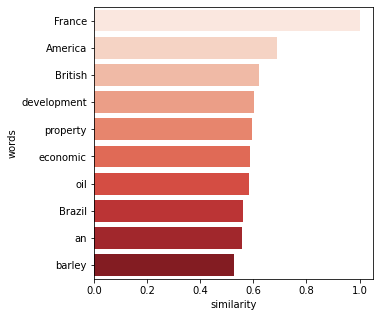

In [53]:
plot_sim(france)


Let's see with other words

In [ ]:
cos_sim_is = cosine_similarity_co_oc_space('is')


In [55]:
is_ = print_first_ten(cos_sim_is)


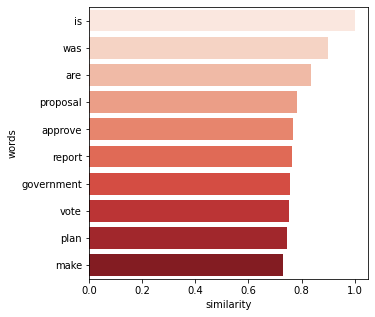

In [56]:
plot_sim(is_)


/tmp/ipykernel_14786/1254940773.py:9: RuntimeWarning: invalid value encountered in double_scalars
  return cosine_up/cosine_down


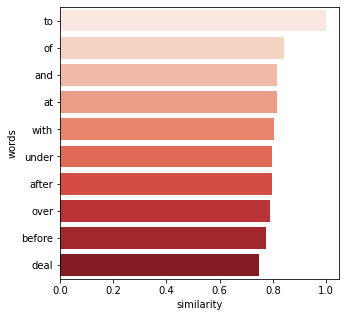

In [57]:
cos_sim_to = cosine_similarity_co_oc_space('to')
to = print_first_ten(cos_sim_to)
plot_sim(to)


## PMI

In [58]:
total_counts = df.sum(axis=1).sum(axis=0)


In [59]:
def ppmi(w1, w2, df):
    sum_oc_w1 = df[w1].to_numpy().sum()
    sum_oc_w2 = df[w2].to_numpy().sum()
    w1_w2_co_oc = df[w1][w2]
#
    P_w1_w2 = w1_w2_co_oc / total_counts
    P_w1 = sum_oc_w1 / total_counts
    P_w2 = sum_oc_w2 / total_counts
    ppmi = np.log2(P_w1_w2 / (P_w1 * P_w2))
    return np.max([ppmi, 0])


In [60]:
ppmi('France', 'to', df)


0.47142997772699025

In [61]:
def ppmi_all_wspace(word):
    ppmi_space = {}
    for w in vocab:
        res = ppmi(w, word, df)
        ppmi_space[w] = res
    return ppmi_space


In [ ]:
fra = ppmi_all_wspace('France')


In [63]:
f_ten = print_first_ten(fra)


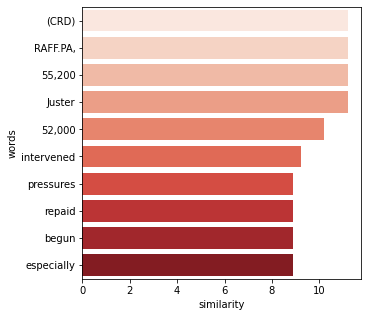

In [64]:
plot_sim(f_ten)


### Note: The results are ridiculousely bad, not even the word *France* is there, there must be an error somewhere, to check later !!

## Part 2 : Word embeddings using pretrained model word2vec

In [65]:
import gensim.models.keyedvectors as word2vec
model = word2vec.KeyedVectors.load_word2vec_format(
    "~/master2-s3/S1/NLP/Cours2/TP/10/model.bin", binary=True)


In [66]:
model.similarity('France', 'Paris')


0.61235493

In [67]:
def word2vec(word):
    sim = {}
    for w in vocab:
        try:
            res = model.similarity(word, w)
            sim[w] = res
        except:
            sim[w] = 0
    return sim


In [68]:
france_similarities = word2vec('France')


In [69]:
w2vfirst10 = print_first_ten(france_similarities)


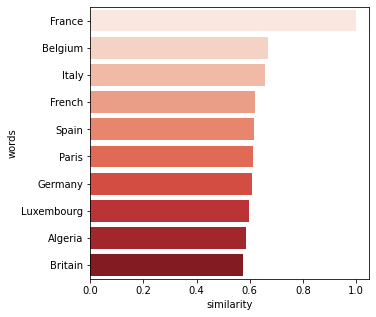

In [70]:
plot_sim(w2vfirst10)


Much better results !

Let's see the most similar to France in the embedings

In [71]:
model.most_similar('France', topn=10)


[('Belgium', 0.6676415801048279),
 ('Italy', 0.6590821743011475),
 ('Nord-Pas-de-Calais-Picardie', 0.6581639051437378),
 ('Haute-Normandie', 0.6502934098243713),
 ('Bourgogne-Franche-Comté', 0.6501458883285522),
 ('Franche-Comté', 0.6463789343833923),
 ('Île-de-France', 0.6424452066421509),
 ('Aquitaine-Limousin-Poitou-Charentes', 0.6404675245285034),
 ('Pays-de-la-Loire', 0.6400671601295471),
 ('Basse-Normandie', 0.6356187462806702)]

## Documents classification 

In [72]:
reuteurs_df


,Unnamed: 0,topics,title,body
0,0,grain,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department\nreported the ...
1,1,earn,CHAMPION PRODUCTS <CH> APPROVES STOCK SPLIT,Champion Products Inc said its\nboard of direc...
2,2,acq,COMPUTER TERMINAL SYSTEMS <CPML> COMPLETES SALE,Computer Terminal Systems Inc said\nit has com...
3,3,earn,COBANCO INC <CBCO> YEAR NET,"Shr 34 cts vs 1.19 dlrs\n Net 807,000 vs 2,..."
4,4,earn,OHIO MATTRESS <OMT> MAY HAVE LOWER 1ST QTR NET,"Ohio Mattress Co said its first\nquarter, endi..."
...,...,...,...,...
7819,7819,money-fx,ECONOMIST URGES MORE TAXES TO LOWER N.Z. DOLLAR,An income tax surcharge and capital\ngains tax...
7820,7820,crude,"IRAN, SOVIET UNION TO SWAP CRUDE, REFINED PROD...",The Soviet Union has agreed to supply\nIran wi...
7821,7821,grain,THAI RICE EXPORTS RISE IN WEEK TO OCTOBER 13,"Thai rice exports rose to 72,987 tonnes\nin th..."
7822,7822,acq,N.Z.'S CHASE CORP MAKES OFFER FOR ENTREGROWTH,Chase Corp Ltd <CHCA.WE> said it will\nmake an...


In [73]:
bodies = reuteurs_df['body']


Here we'll try to get the vector associated to each word of a body from bodies from the embeddings uploaded earlier, then, we'll try to create another dataframe with the vectors and it's associated target (topic).
Finally, split the dataframe to train and test slices, then, train and test a model ( perhaps Logistic Reg).

In [74]:
docs_vectors = pd.DataFrame() 
stop_words = spacy.lang.en.stop_words.STOP_WORDS

for body in bodies:  
    preprocessed_body = preprocess_text_clean(body)
    temp = pd.DataFrame()  
    
    for word in preprocessed_body.split(' '):
        # if word is not present in stopwords then (try)
        if word not in stop_words:
            try:
                # try to get the vector from model (embeddingd) is it exists
                word_vec = model[word]
                temp = temp.append(pd.Series(word_vec), ignore_index=True)
            except:
                # if it's not than just pass
                pass
    # take the average of the columns
    doc_vector = temp.mean()
    # append each body to the final df
    docs_vectors = docs_vectors.append(doc_vector, ignore_index=True)
    

In [75]:
docs_vectors = docs_vectors.dropna()


In [76]:
pd.isnull(docs_vectors).sum().sum()


0

In [77]:
docs_vectors['topics'] = reuteurs_df['topics']
docs_vectors = docs_vectors.dropna()


In [78]:
X_train, X_test, y_train, y_test = train_test_split(docs_vectors.drop('topics', axis=1),
                                                    docs_vectors['topics'],
                                                    test_size=0.3,
                                                    random_state=42)


In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)
predicted_ = model.predict(X_test)


In [80]:
print(" Accuracy:", metrics.accuracy_score(y_test, predicted_))
print("Precision:", metrics.precision_score(
    y_test, predicted_, average='weighted'))
print("Recall:", metrics.recall_score(y_test, predicted_, average='weighted'))
print("score_f1:", metrics.f1_score(y_test, predicted_, average='weighted'))


 Accuracy: 0.957288765088208
Precision: 0.9576488658735594
Recall: 0.957288765088208
score_f1: 0.9572741487561038


In [ ]:
clf = LogisticRegressionCV(cv=10, random_state=0)

clf.fit(X_train, y_train)
predicted_ = clf.predict(X_test)


In [82]:
print(" Accuracy:", metrics.accuracy_score(y_test, predicted_))
print("Precision:", metrics.precision_score(
    y_test, predicted_, average='weighted'))
print("Recall:", metrics.recall_score(y_test, predicted_, average='weighted'))
print("score_f1:", metrics.f1_score(y_test, predicted_, average='weighted'))


 Accuracy: 0.9633240482822656
Precision: 0.9634809853976436
Recall: 0.9633240482822656
score_f1: 0.9633210717770488


of two things, either the model is really good or there is overfitting.